In [5]:
from cluster import cluster as cl
rc = cl.start_cluster('homard', 16)

In [6]:
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [7]:
dv = rc[:]

In [76]:
%%px

maxorbs = 1.e6

import numpy as np
mp = 5*3.e-6 # 5 earth masses
gamma = (2./3.*mp)**(1./3.) # Hill radius with factor of a taken out
a1 = 0.05 # semimajor axis of innermost planet in AU
imax = 1.*np.pi/180. # maximum inclination (uniform distribution)
emax = 2.e-2 # maximum eccentricity (uniform distribution)
betamin = 5.
betamax = 9.

In [79]:
import rebound
import random
import os
import time

def system(sim_id):
    random.seed(sim_id)
    
    beta = random.uniform(betamin, betamax)
    a2 = a1 + beta*gamma*a1
    a3 = a2 + beta*gamma*a2
    
    sim = rebound.Simulation()
    sim.integrator="whfast"
    sim.G = 4*np.pi**2
    sim.exit_min_distance = a1*gamma # use smaller hill radius as exit condition
    
    
    sim.add(m=1.)
    sim.add(m=mp, a=a1, e=random.random()*emax, pomega=random.random()*2.*np.pi, inc=random.random()*imax, Omega=random.random()*2.*np.pi, f=random.random()*2.*np.pi)
    sim.add(m=mp, a=a2, e=random.random()*emax, pomega=random.random()*2.*np.pi, inc=random.random()*imax, Omega=random.random()*2.*np.pi, f=random.random()*2.*np.pi)
    sim.add(m=mp, a=a3, e=random.random()*emax, pomega=random.random()*2.*np.pi, inc=random.random()*imax, Omega=random.random()*2.*np.pi, f=random.random()*2.*np.pi)
    sim.move_to_com()
    ps = sim.particles
    
    P0 = ps[1].P
    tmax = maxorbs * P0 # number of inner planet orbital periods to integrate
    sim.dt = P0/500.
    
    features = [maxorbs, mp, gamma]
    for p in ps[1:]:
        features = features + [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f, p.x, p.y, p.z, p.vx, p.vy, p.vz]
        
    stable = [True] # assume it's stable and update if not
    
    E0 = sim.calculate_energy()
    t0 = time.time()
    try:
        sim.integrate(tmax)
    except rebound.Encounter as error:
        stable = [False]
    
    features = stable+[sim.t/P0]+features+[np.abs((sim.calculate_energy()-E0)/E0), time.time()-t0]
    fname = '/mnt/raid-cita/dtamayo/Stability/data/whfastdte-3'+str(os.getpid())+'.csv'
    with open(fname, 'a') as f:
        f.write(str(sim_id))
        for feature in features:
            f.write(',{0}'.format(feature))
        f.write('\n')
        
    return features

In [80]:
Nsystems=2000
res = dv.map(system, list(range(Nsystems)))

In [85]:
import pandas as pd
import numpy as np

columns = ['Sim_ID', 'Stable', 'Norbits_instability', 'Norbits', 'Mplanet', 'RH/a']
for i in ['1', '2', '3']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i, 'x'+i, 'y'+i, 'z'+i, 'vx'+i, 'vy'+i, 'vz'+i]
columns += ['Rel_Eerr', 'integ_time']

frames = []
path = '/mnt/raid-cita/dtamayo/Stability/data/'
for f in os.listdir(path):
        if f.startswith('ias'):
            frames.append(pd.read_csv(path+f, names=columns, index_col=0))

df = pd.concat(frames)
df = df.sort_index()
df.tail()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,Omega3,f3,x3,y3,z3,vx3,vy3,vz3,Rel_Eerr,integ_time
Sim_ID,,,,,,,,,,,,,,,,,,,,,
1995,True,1000000.000000,1000000.0,0.000015,0.021544,0.05,0.01118,0.009089,-1.079974,0.010988,...,2.967275,-0.849203,-0.067186,0.010875,0.000015,-3.710960,-23.860270,0.396331,1.221454e-13,920.464203
1996,False,393070.901091,1000000.0,0.000015,0.021544,0.05,0.01118,0.011170,4.751147,0.009788,...,2.553637,1.060472,0.006214,-0.066580,0.000532,24.201111,2.232317,-0.156514,3.073272e-14,415.862748
1997,True,1000000.000000,1000000.0,0.000015,0.021544,0.05,0.01118,0.004709,1.389463,0.011670,...,0.639780,-0.803942,0.056566,-0.039027,-0.000454,13.578741,19.784498,0.054182,1.261405e-14,884.219790
1998,True,1000000.000000,1000000.0,0.000015,0.021544,0.05,0.01118,0.002514,-1.615616,0.001747,...,0.170469,-2.806279,0.001103,-0.067801,-0.000308,24.000226,0.476752,-0.016553,3.729223e-14,1005.072442
1999,False,35087.808064,1000000.0,0.000015,0.021544,0.05,0.01118,0.002846,-2.724788,0.016104,...,1.764170,-1.827689,-0.029586,0.055161,0.000047,-22.018055,-12.027872,0.061370,4.347926e-15,33.730164


In [88]:
df.to_csv(path+'1e6dataset.csv', encoding='ascii')

In [90]:
df = pd.read_csv(path+'1e6dataset.csv', index_col=0)
df.tail()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,Omega3,f3,x3,y3,z3,vx3,vy3,vz3,Rel_Eerr,integ_time
Sim_ID,,,,,,,,,,,,,,,,,,,,,
1995,True,1000000.000000,1000000.0,0.000015,0.021544,0.05,0.01118,0.009089,-1.079974,0.010988,...,2.967275,-0.849203,-0.067186,0.010875,0.000015,-3.710960,-23.860270,0.396331,1.221454e-13,920.464203
1996,False,393070.901091,1000000.0,0.000015,0.021544,0.05,0.01118,0.011170,4.751147,0.009788,...,2.553637,1.060472,0.006214,-0.066580,0.000532,24.201111,2.232317,-0.156514,3.073272e-14,415.862748
1997,True,1000000.000000,1000000.0,0.000015,0.021544,0.05,0.01118,0.004709,1.389463,0.011670,...,0.639780,-0.803942,0.056566,-0.039027,-0.000454,13.578741,19.784498,0.054182,1.261405e-14,884.219790
1998,True,1000000.000000,1000000.0,0.000015,0.021544,0.05,0.01118,0.002514,-1.615616,0.001747,...,0.170469,-2.806279,0.001103,-0.067801,-0.000308,24.000226,0.476752,-0.016553,3.729223e-14,1005.072442
1999,False,35087.808064,1000000.0,0.000015,0.021544,0.05,0.01118,0.002846,-2.724788,0.016104,...,1.764170,-1.827689,-0.029586,0.055161,0.000047,-22.018055,-12.027872,0.061370,4.347926e-15,33.730164


In [9]:
cl.shutdown_cluster('homard', rc)

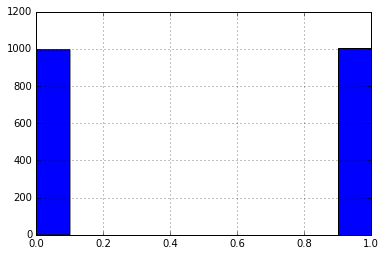

In [75]:
%matplotlib inline
df['Stable'].hist()